# DCGAN For Generating images of numbers 0-9

Here we will use a deep convolution GAN trained on the MNIST dataset to generate images of numbers ranging 0-9.

# Mounting Google Drive

In [3]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [4]:
#import os
#os.chdir('/content/drive/MyDrive/Projects/DCGAN')

### Goal
In this notebook, we're going to create a GAN using the MNIST dataset. We will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested!*


![Generator architecture](https://drive.google.com/uc?export=view&id=1BZeLSCXDb2iGQslXV8EAwBtROvE6QAVX)

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf)

## Getting Started

#### DCGAN
Here are the main features of DCGAN : 


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

# Importing Required Libraries

In [5]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator
The first component we will make is the generator. Instead of passing in the image dimension, we will pass the number of image channels to the generator. This is because with DCGAN, we use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

We will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, we will need to write a function to create a single block for the generator's neural network.

Since in DCGAN the activation function will be different for the output layer, we will need to check what layer is being created. 


In [6]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels,kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channels),
                nn.ReLU(inplace=True)
                
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels,kernel_size=kernel_size, stride=stride),
                nn.Tanh()
                
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator
The second component we need to create is the discriminator.

We will use 3 layers in our discriminator's neural network. Like with the generator, we will need to create the function to create a single neural network block for the discriminator.

In [7]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels,kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(num_features=output_channels),
                nn.LeakyReLU(negative_slope=0.2)
                
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.Conv2d(in_channels=input_channels, out_channels=output_channels,kernel_size=kernel_size, stride=stride)
                
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training
Now we can put it all together!
Remember that these are our parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

In [9]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, read more about here:
# https://distill.pub/2017/momentum/ 
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Now, we can initialize our generator, discriminator, and optimizers.

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Here's roughly the progression we should be expecting.
![MNIST Digits Progression](https://drive.google.com/uc?export=view&id=1BDFYgKMc3dnZABfl3yq8KEgjee4hfMLi)


Step 500: Generator loss: 0.9348257422447204, discriminator loss: 0.5119728009700775


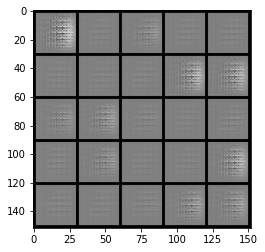

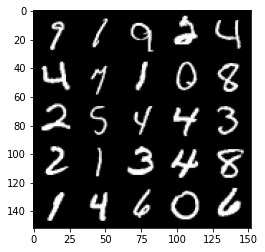

Step 1000: Generator loss: 2.015779520690441, discriminator loss: 0.21397836181521399


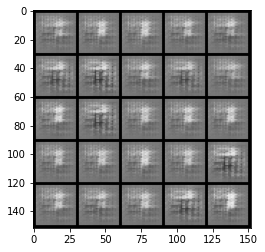

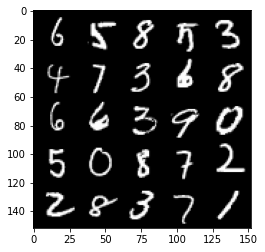

Step 1500: Generator loss: 1.7217808872908347, discriminator loss: 0.3712476992160087


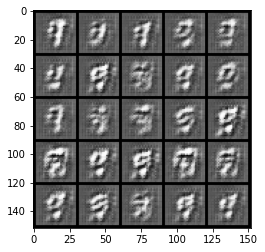

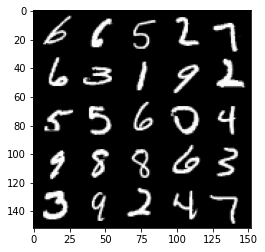

Step 2000: Generator loss: 1.2650979934930804, discriminator loss: 0.4764338389039036


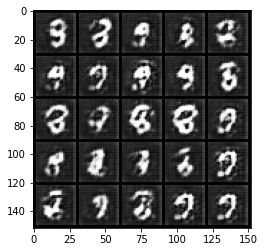

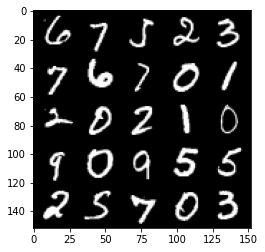

Step 2500: Generator loss: 1.1429562275707716, discriminator loss: 0.5006591392159462


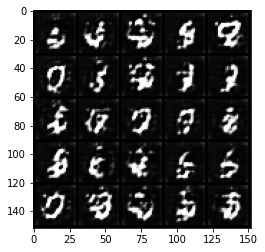

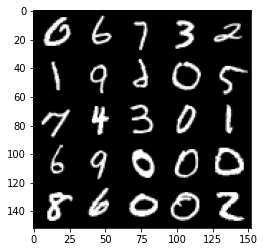

Step 3000: Generator loss: 0.9617157678604109, discriminator loss: 0.5557392500638957


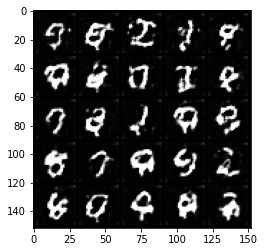

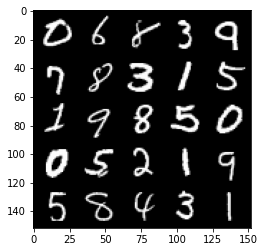

Step 3500: Generator loss: 0.9078670913577078, discriminator loss: 0.5928814826011656


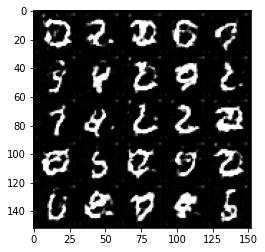

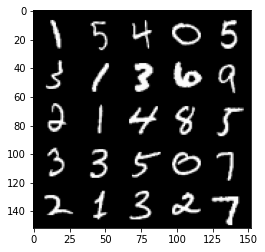

Step 4000: Generator loss: 0.8694598523378392, discriminator loss: 0.6140647480487822


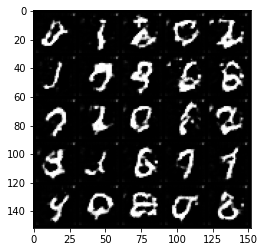

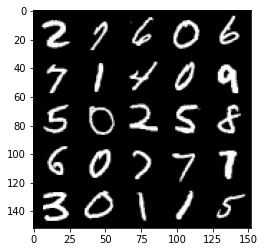

Step 4500: Generator loss: 0.8561879143118851, discriminator loss: 0.6241489472389221


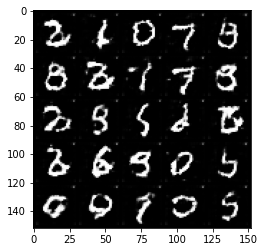

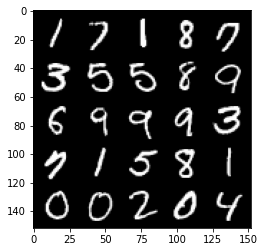

Step 5000: Generator loss: 0.8444072259068489, discriminator loss: 0.6348710876703256


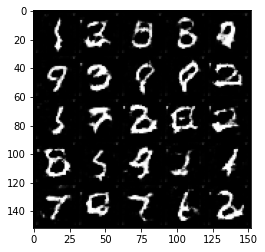

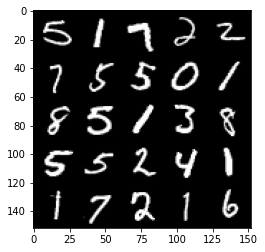

Step 5500: Generator loss: 0.8239383016228675, discriminator loss: 0.6429335784912105


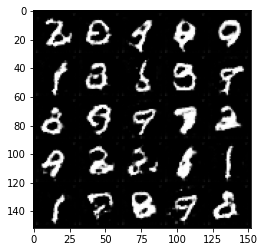

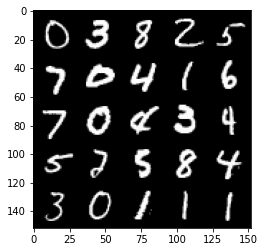

Step 6000: Generator loss: 0.8094969215989116, discriminator loss: 0.6495214924812319


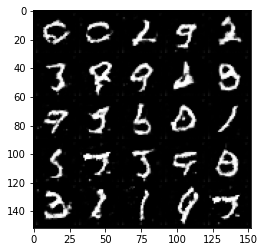

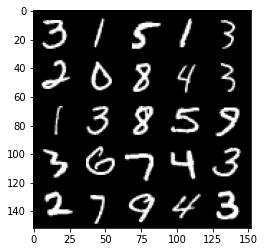

Step 6500: Generator loss: 0.794473487734795, discriminator loss: 0.6591429597139361


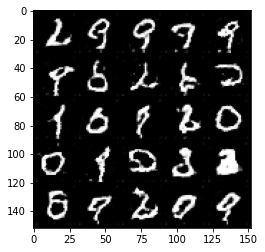

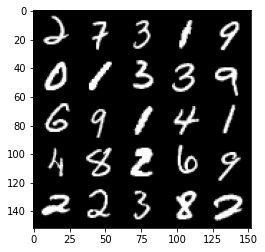

Step 7000: Generator loss: 0.7855151307582847, discriminator loss: 0.6668801791667941


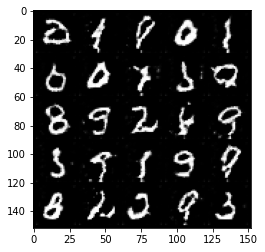

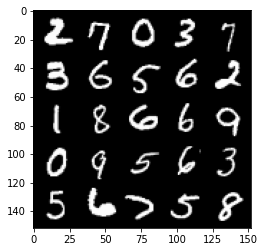

Step 7500: Generator loss: 0.7787051237821574, discriminator loss: 0.6727172540426251


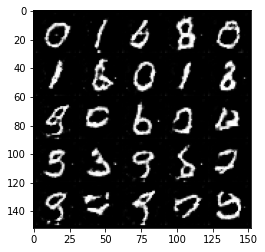

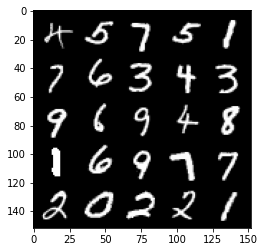

Step 8000: Generator loss: 0.7759487278461451, discriminator loss: 0.6743911398649213


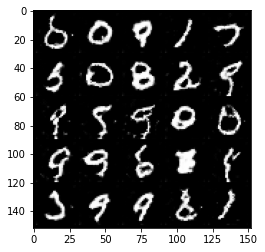

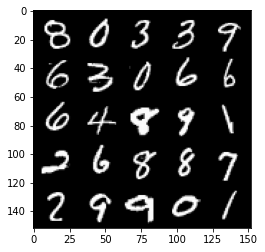

Step 8500: Generator loss: 0.7658069645762445, discriminator loss: 0.6770762794017785


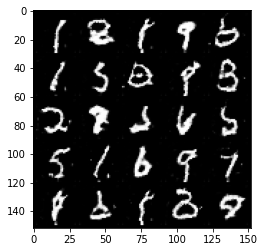

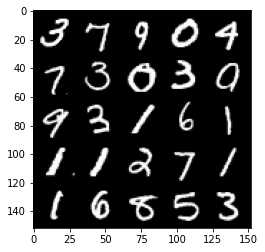

Step 9000: Generator loss: 0.764032593488694, discriminator loss: 0.6804727014303208


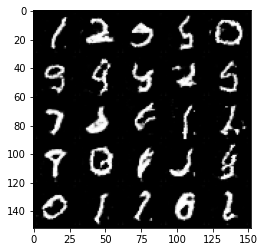

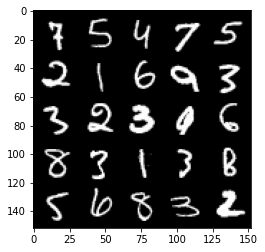

Step 9500: Generator loss: 0.7624485970139496, discriminator loss: 0.6819392906427383


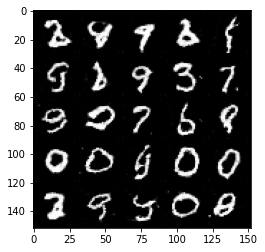

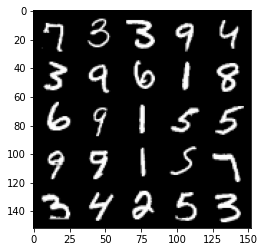

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
